In [ ]:
!sudo apt update
# PDF
!apt install poppler-utils
!apt install tesseract-ocr
!apt install libtesseract-dev
%pip install langchain-community
%pip install langchain-unstructured
%pip install langchain-huggingface
%pip install nltk --upgrade
%pip install unstructured[pdf]

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,535 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,458 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main a

In [ ]:
# Clone our repo to obtain the data
!git clone https://github.com/andrzejczukm/NLP-RAG.git

fatal: destination path 'NLP-RAG' already exists and is not an empty directory.


# Loading data

In [ ]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from langchain_core.documents import Document
# from langchain_unstructured import UnstructuredLoader
from langchain.document_loaders.unstructured import UnstructuredFileLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, TextSplitter, CharacterTextSplitter
from unstructured.cleaners.core import clean_extra_whitespace, group_broken_paragraphs

In [ ]:
INPUT_PATH = './NLP-RAG/data'

In [ ]:
post_processors = [
    clean_extra_whitespace,
    group_broken_paragraphs,
]

In [ ]:
documents_loaders: list[UnstructuredFileLoader] = []

for filename in os.listdir(INPUT_PATH):
    if not filename.endswith('.pdf') and not filename.endswith('.txt'):
        continue

    documents_loaders.append(UnstructuredFileLoader(
        os.path.join(INPUT_PATH, filename),
        post_processors=post_processors,
        paragraph_grouper=group_broken_paragraphs,
    ))

In [ ]:
chunk_size = 2000

text_splitter = RecursiveCharacterTextSplitter(
    separators=['\n\n', '.', '?', '\n'],
    chunk_size=chunk_size,
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
    keep_separator="end"
)


In [ ]:
# this takes a while
passages: dict[str, Document] = {}

for document in documents_loaders:
    passages_for_doc = document.load_and_split(text_splitter)
    passages[document.file_path] = passages_for_doc

In [ ]:
# merging all documents into a single list
passages_list = list(itertools.chain(*passages.values()))

# EDA

### Example passage from the middle

In [ ]:
passages_list[len(passages_list) // 2]

Document(metadata={'source': './NLP-RAG/data/bronte_jane_eyre.txt'}, page_content='Tea over and the tray removed, she again summoned us to the fire; we sat one on each side of her, and now a conversation followed between her and Helen, which it was indeed a privilege to be admitted to hear.\n\nMiss Temple had always something of serenity in her air, of state in her mien, of refined propriety in her language, which precluded deviation into the ardent, the excited, the eager: something which chastened the pleasure of those who looked on her and listened to her, by a controlling sense of awe; and such was my feeling now: but as to Helen Burns, I was struck with wonder.\n\nThe refreshing meal, the brilliant fire, the presence and kindness of her beloved instructress, or, perhaps, more than all these, something in her own unique mind, had roused her powers within her. They woke, they kindled: first, they glowed in the bright tint of her cheek, which till this hour I had never seen but pale 

### Convert to dataframe for easier analysing

In [ ]:
passages_df = pd.DataFrame({
    'document': [p.metadata['source'].split('/')[-1] for p in passages_list],
    'content': [p.page_content for p in passages_list],
    'length': [len(p.page_content) for p in passages_list],
})

### Inspect books count

In [ ]:
print(f'Total books: {len(passages_df["document"].unique())}')

Total books: 35


### Analyse the number of passages across documents

In [ ]:
docs_lengths_df = passages_df.groupby('document')\
    .count()\
    .reset_index()\
    .drop(columns=['content'])\
    .rename(columns={'length': 'passages_count'})\
    .sort_values(by='passages_count', ascending=False)
docs_lengths_df

,document,passages_count
3,cervantes_don_quixote.txt,1565
11,dumas_the_count_of_monte_cristio.txt,1551
7,dostoyevski_the_brothers_karamazov.txt,1271
16,joyce_ulysses.pdf,921
20,melville_moby_dick.txt,808
8,dostoyevsky_crime_and_punishment.txt,745
13,homer_iliad.txt,736
2,bronte_jane_eyre.txt,637
0,alcott_little_women.txt,635
6,dickens_great_expectations.txt,607


In [ ]:
print(f'The total number of passages: {docs_lengths_df["passages_count"].sum()}')

The total number of passages: 14864


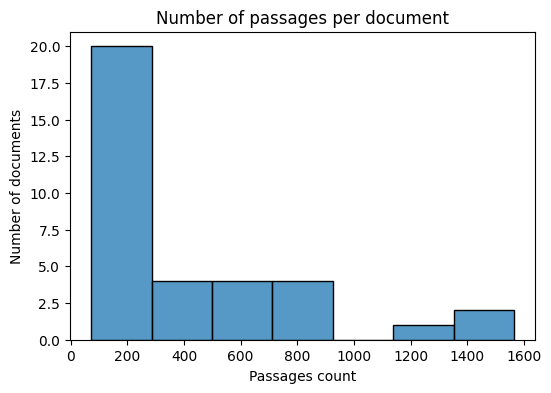

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(docs_lengths_df['passages_count'])
plt.title('Number of passages per document')
plt.xlabel('Passages count')
plt.ylabel('Number of documents')
plt.show()

### Analyse passages

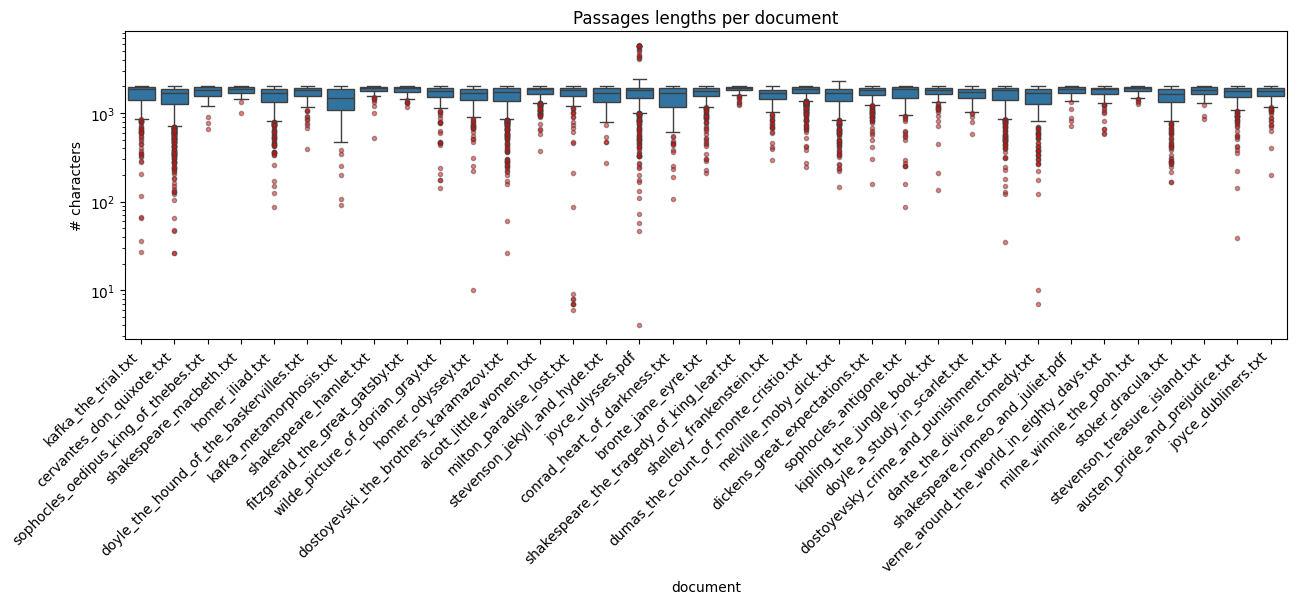

In [ ]:
flierprops = dict(marker='o', markersize=3, linestyle='none', markerfacecolor='r', alpha=0.5)

plt.figure(figsize=(15, 4))
sns.boxplot(
    data=passages_df,
    y='length',
    x='document',
    log_scale=10,
    flierprops=flierprops  # Apply custom outlier settings
)
plt.title('Passages lengths per document')
plt.ylabel('# characters')
plt.xticks(rotation=45, ha='right')
plt.show()

#### troublesome boxplots
kafka_metamorphosis, milton_paradise_lost, homer_iliad, kafka_the_trial,conrad_heart_of_darkness have abnormal boxplots, below - kde plots for these books' passage lenghts.
It seems, as if the passage generator mistakenly takes each line of the txt file as a single passage, but gutenberg project adds these newlines artificially - they don't exist in the pdfs, only in txt.

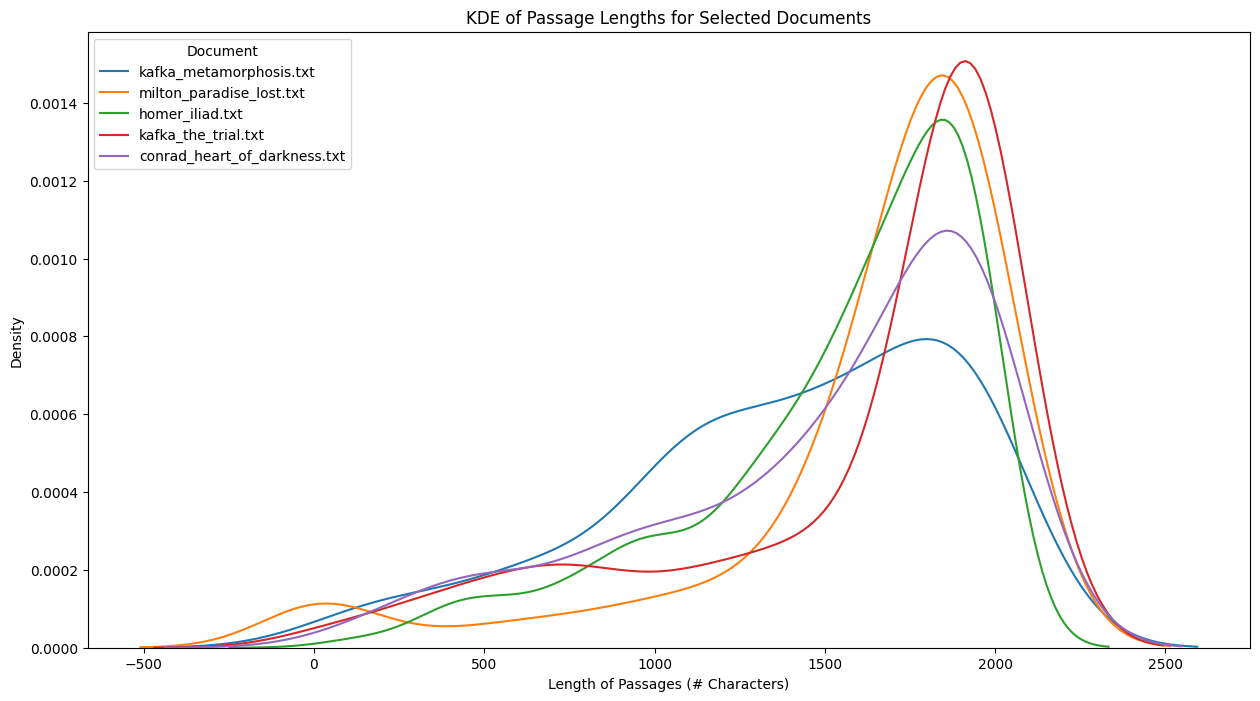

In [ ]:
selected_documents = [
    "kafka_metamorphosis.txt",
    "milton_paradise_lost.txt",
    "homer_iliad.txt",
    "kafka_the_trial.txt",
    "conrad_heart_of_darkness.txt",
]
# Initialize the plot
plt.figure(figsize=(15, 8))

# Add KDEs for each document with individual labels
for document in selected_documents:
    sns.kdeplot(
        data=passages_df[passages_df['document'] == document],
        x='length',
        label=document,  # Label each KDE
        fill=False,      # No shaded area under the curves
    )

# Add title and axis labels
plt.title("KDE of Passage Lengths for Selected Documents")
plt.xlabel("Length of Passages (# Characters)")
plt.ylabel("Density")

# Display legend
plt.legend(title='Document')
plt.show()



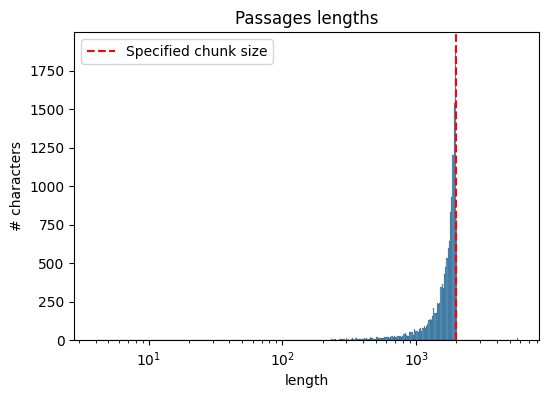

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(
    passages_df['length'],
    log_scale=10,
)
plt.axvline(
    x=chunk_size,
    color='red',
    linestyle='--',
    label='Specified chunk size',
)
plt.title('Passages lengths')
plt.ylabel('# characters')
plt.legend()
plt.show()

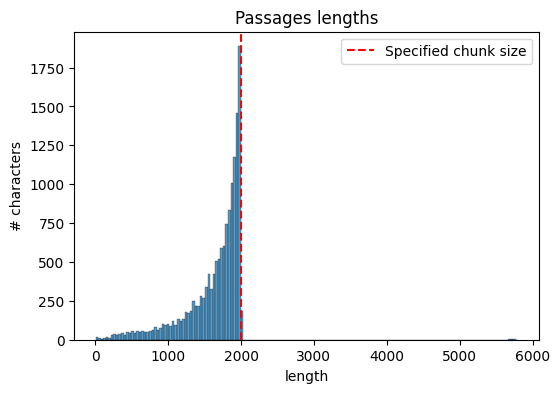

In [ ]:
plt.figure(figsize=(6, 4))
sns.histplot(
    passages_df['length'],
    # log_scale=10,
)
plt.axvline(
    x=chunk_size,
    color='red',
    linestyle='--',
    label='Specified chunk size',
)
plt.title('Passages lengths')
plt.ylabel('# characters')
plt.legend()
plt.show()

In [ ]:
passages_df['length'].describe()

,length
count,14864.000000
mean,1638.770385
std,418.742842
min,4.000000
25%,1490.000000
50%,1778.000000
75%,1921.000000
max,5803.000000


### Inspect the longest and the shortest documents

In [ ]:
print(f'The number of passages with the length of 1: {np.sum(passages_df["length"] == 1)}')

The number of passages with the length of 1: 0


In [ ]:
passages_df[passages_df['length'] == 1]

,document,content,length


In [ ]:
print(f'The number of passages with the length less than 10: {np.sum(passages_df["length"] < 10)}')

The number of passages with the length less than 10: 9


In [ ]:
passages_df.loc[passages_df['length'] < 10]

,document,content,length
5999,milton_paradise_lost.txt,Book II,7
6028,milton_paradise_lost.txt,Book III,8
6049,milton_paradise_lost.txt,Book IV,7
6079,milton_paradise_lost.txt,Book V,6
6104,milton_paradise_lost.txt,Book VI,7
6128,milton_paradise_lost.txt,Book VII,8
6145,milton_paradise_lost.txt,Book VIII,9
6618,joyce_ulysses.pdf,Hans,4
12712,dante_the_divine_comedy.txt,CANTO X,7


In [ ]:
longest_docs = passages_df.nlargest(10, 'length')
longest_docs

,document,content,length
7158,joyce_ulysses.pdf,white as a sheet frightened out of his wits ma...,5803
7146,joyce_ulysses.pdf,on copied from some old opera yes and he was g...,5753
7145,joyce_ulysses.pdf,anear me drawers drawers the whole blessed tim...,5749
7166,joyce_ulysses.pdf,Revueltas and Pisimbo and Mrs Opisso in Govern...,5749
7141,joyce_ulysses.pdf,damn cooking and throwing out the dirt I gave ...,5728
7161,joyce_ulysses.pdf,every little fiddlefaddle her vagina and her c...,5727
7151,joyce_ulysses.pdf,was just a p c to tell you I sent the little p...,5721
7154,joyce_ulysses.pdf,sweetheart when a boy it never entered my head...,5718
7157,joyce_ulysses.pdf,performance I put out the light too so then th...,5717
7142,joyce_ulysses.pdf,voice no I never in all my life felt anyone ha...,5711


In [ ]:
longest_docs[longest_docs.length>2000]

,document,content,length
7158,joyce_ulysses.pdf,white as a sheet frightened out of his wits ma...,5803
7146,joyce_ulysses.pdf,on copied from some old opera yes and he was g...,5753
7145,joyce_ulysses.pdf,anear me drawers drawers the whole blessed tim...,5749
7166,joyce_ulysses.pdf,Revueltas and Pisimbo and Mrs Opisso in Govern...,5749
7141,joyce_ulysses.pdf,damn cooking and throwing out the dirt I gave ...,5728
7161,joyce_ulysses.pdf,every little fiddlefaddle her vagina and her c...,5727
7151,joyce_ulysses.pdf,was just a p c to tell you I sent the little p...,5721
7154,joyce_ulysses.pdf,sweetheart when a boy it never entered my head...,5718
7157,joyce_ulysses.pdf,performance I put out the light too so then th...,5717
7142,joyce_ulysses.pdf,voice no I never in all my life felt anyone ha...,5711


In [ ]:
longest_docs.iloc[0, 1]

'white as a sheet frightened out of his wits making as much noise as he possibly could for the burglars benefit there isnt much to steal indeed the Lord knows still its the feeling especially now with Milly away such an idea for him to send the girl down there to learn to take photographs on account of his grandfather instead of sending her to Skerrys academy where shed have to learn not like me getting all at school only hed do a thing like that all the same on account of me and Boylan thats why he did it Im certain the way he plots and plans everything out I couldnt turn round with her in the place lately unless I bolted the door first gave me the fidgets coming in without knocking first when I put the chair against the door just as I was washing myself there below with the glove get on your nerves then doing the loglady all day put her in a glasscase with two at a time to look at her if he knew she broke off the hand off that little gimcrack statue with her roughness and carelessnes

### Word cloud

In [ ]:
all_passages_combined = ' '.join(passages_df['content'].tolist())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
)
wordcloud.generate(all_passages_combined);

In [ ]:
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Word cloud without single character passages

In [ ]:
filtered_passages_df = passages_df[passages_df['content'].str.len() > 1]

all_passages_combined = ' '.join(filtered_passages_df['content'].tolist())

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Dark2'
)
wordcloud.generate(all_passages_combined)

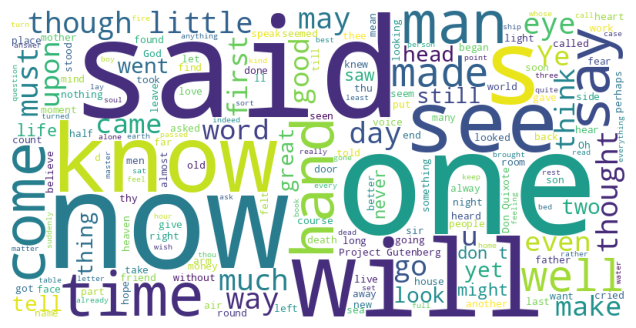

In [ ]:
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()